<a href="https://colab.research.google.com/github/allenthemartian/CNN/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.  

There are two main benefits:
1. Can leverage an existing NN architecture proven to work on problems similar to our own.  
2. Can leverage a working NN architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our data.

In [ ]:
from google.colab.output import eval_js
def set_cell_size(height=250):
  '''
  Resizes the output cell size to desired height.

  Args:
    `height`: 
      
  '''
  height = str(height)
  return eval_js(f'google.colab.output.setIframeHeight({height})')

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-09-06 05:16:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  50.9MB/s    in 3.2s    

2021-09-06 05:16:42 (50.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images are there in each directory:

import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.


In deep learning, CAPITAL LETTERS are used to denote variables -> Often means: **Hyperparameters**.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          class_mode="categorical",
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True)

print("Testing Images:")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        class_mode="categorical",
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=True)

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


We have 10 times less examples for our model to learn patterns from.

## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks.

* Tracking experiments with the **TensorBoard Callback**.
> `class TensorBoard`: Enable visualizations for TensorBoard.
* Model checkpoint with the **ModelCheckpoint Callback**.
> `class ModelCheckpoint`: Callback to save the Keras model or model weights at some frequency. (at every epoch instead at the end of every training)
* Stopping a model from training (before it trains too long and overfits) with the **EarlyStopping Callback**.
> `class EarlyStopping`: Stop training when a monitored metric has stopped improving.

In [ ]:
# Lets create a function to Build a TensorFlow callback

# Create TensorBoard Callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback (dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/  

**Resource:**  
> https://paperswithcode.com/task/image-classification  
> https://arxiv.org/abs/1905.11946

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1  




In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    `model_url` (str): A TensorFlow Hub feature extraction URL.
    `num_classes` (int): Number of output neurons in the output layer,
      should be equal to number of target classes, Default = 10.

  Returns:
    An uncompiled Keras Sequential model with `model_url` as feature extractor          
    layer and Dense output layer with `num_classes` output neurons.
  '''

  # Download the pre-trained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model 

### Creating and Testing ResNet TensorFlow Hub Feature Extraction Model

In [ ]:
train_data_10_percent.num_classes

10

In [ ]:
# 1. Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# 2. Compile our resnet model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps = len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20210906-051659
Epoch 1/5
24/24 [==============================] - 58s 1s/step - loss: 1.7824 - accuracy: 0.4120 - val_loss: 1.0976 - val_accuracy: 0.6748
Epoch 2/5
24/24 [==============================] - 22s 932ms/step - loss: 0.8508 - accuracy: 0.7587 - val_loss: 0.8318 - val_accuracy: 0.7408
Epoch 3/5
24/24 [==============================] - 22s 929ms/step - loss: 0.5962 - accuracy: 0.8187 - val_loss: 0.7265 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 22s 927ms/step - loss: 0.4605 - accuracy: 0.8800 - val_loss: 0.6780 - val_accuracy: 0.7772
Epoch 5/5
24/24 [==============================] - 22s 923ms/step - loss: 0.3630 - accuracy: 0.9187 - val_loss: 0.6503 - val_accuracy: 0.7848


Wow!  

That. Is. Incredible. Our transfer learning feature extractor model outperformed ALL of the previous models we built by hand..(substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves
# Tidbit: You could put a function like this into a script called "helper.py" and import it when you need it.

import matplotlib.pyplot as plt

# Plot the validation & training curves

def plot_loss_curves(history):
  '''
  Returns seperate loss curves for training and validation metrics.

  Args:
    `history`: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  '''

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  # plt.figure((2, 1, 1), figsize=(10, 7))
  plt.plot(epochs, loss, label="training_loss")
  # plt.figure((2, 2, 2), figsize=(10, 7))
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();



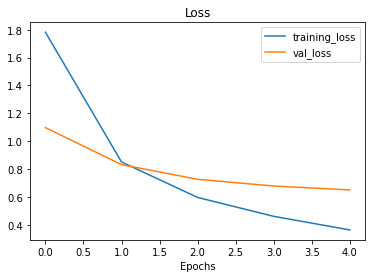

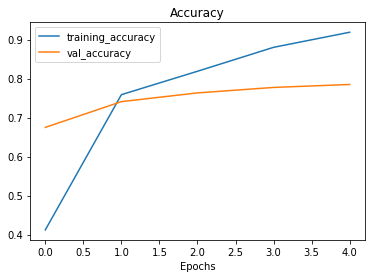

In [ ]:
plot_loss_curves(resnet_history)

### Creating and Testing EfficientBo TensorFlow Hub Feature Extraction model

Details on EfficientNetB0: [Google AI Blog](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# 1. Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# 2. Compile the model
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                           loss="categorical_crossentropy",
                           metrics=["accuracy"])

EPOCHS =5

# 3. Fit the EfficientNet model to 10% of the training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=EPOCHS,
                                              validation_data=test_data,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210906-051941
Epoch 1/5
24/24 [==============================] - 33s 1000ms/step - loss: 1.8043 - accuracy: 0.4680 - val_loss: 1.2501 - val_accuracy: 0.7412
Epoch 2/5
24/24 [==============================] - 19s 820ms/step - loss: 1.0327 - accuracy: 0.7800 - val_loss: 0.8391 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 19s 817ms/step - loss: 0.7417 - accuracy: 0.8467 - val_loss: 0.6813 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.5970 - accuracy: 0.8733 - val_loss: 0.5966 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 19s 808ms/step - loss: 0.5073 - accuracy: 0.8920 - val_loss: 0.5467 - val_accuracy: 0.8652


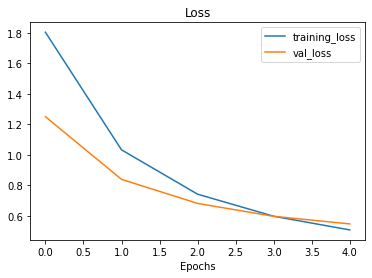

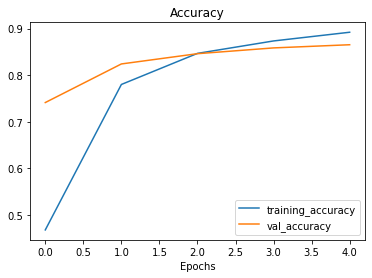

In [ ]:
plot_loss_curves(efficientnet_history)

The ideal scenario of these curves is to line up, and with further training, the model's performance will keep improving.

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.count_params()

4062374

In [ ]:
def count_params(model):

  '''
  Args:
    `model`: Pass in TF model

  Returns:
  
  Total Parameters,
  Trainable Parameters,
  Non-Trainable Parameters
  '''

  import tensorflow.keras.backend as K
  import numpy as np

  trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
  non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

  print(f"Total params for: {(trainable_count + non_trainable_count):,}")
  print(f"Trainable params: {trainable_count:,}")
  print(f"Non-trainable params: {non_trainable_count:,}")

In [ ]:
count_params(efficientnet_model)

Total params for: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564


In [ ]:
count_params(resnet_model)

Total params for: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800


In [ ]:
# How many layers does our effiecientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of Transfer Learning

* **As is** Transfer Learning - Using an existing model with no changes whatsoever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **Feature Extraction** Transfer Learning - Use the preferred patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes of ImageNet -> 10 classes of Food)
* **Fine-Tuning** Transfer Learning - Use the prelearned patterns of an existing model and *fine-tune* many or all of the underlying layers (including new output layers)  

  * We might unfreeze some of the layers and update the parameters (weights) w/ our own custom dataset.  

  * Typically requires more data than feature extraction



## Comparing our models results using TensorBoard  

* A way to **visually explore** your machine learning models performance and internals.  

* Host, track and share your machine leraning experiments on **TensorBoard.dev**  

>* 🔑 **Note:** When you upload the things to TensorBoard.dev, your experiments are public.  
>
>* So if you're running private experiments (things you don't want others to see) do not upload them to **TensorBoard.dev**

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub Feature Extraction Model architectures using 10% of the training data" \
  --one_shot

2021-09-06 05:21:40.713221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-06 05:21:40.735808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-06 05:21:40.736365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/by17PCbOSBeqgh8LAFPz4g/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-09-06 05:22:38.530084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-06 05:22:38.545252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-06 05:22:38.545754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/v6WRIGYKT1GdEWvfznwGAQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub Feature Extraction Model architectures using 10% of the training data
	Id                   v6WRIGYKT1GdEWvfznwGAQ
	Created              2021-09-06 05:22:31 (14 seconds ago)
	U

In [ ]:
# If you've uploaded private data and you want to delete the data
# Delete an experiment
# !tensorboard dev delete --experiment_id 2Tqp0ysOTaabPALrYB99RA

In [ ]:
# Confirm the deletion by rechecking what experiments you have left
!tensorboard dev list

2021-09-06 05:22:47.883163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-06 05:22:47.891055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-06 05:22:47.891591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/v6WRIGYKT1GdEWvfznwGAQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub Feature Extraction Model architectures using 10% of the training data
	Id                   v6WRIGYKT1GdEWvfznwGAQ
	Created              2021-09-06 05:22:31 (22 seconds ago)
	U